### 1. Generating Data

$y_{(\text{n}\times 1)} = $
$\text{X}_{(\text{n}\times\text{p})}$
$\beta^{\text{true}}_{(\text{p}\times\text{1})}$
$+\epsilon_{(\text{n}\times\text{1})}$

In [113]:
import navigator_updater.static.css
import numpy as np
from numpy import linalg
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

def get_W(p):
    list = []
    list.append(np.zeros((p,p)))
    list.append(np.eye(p))
    return list

def transformation(y, X, W, ev):    # ev: eigenvalue
    # dimension of z: n+p
    z = np.vstack((y, np.zeros((len(W),1) )))

    # dimension of U: (n+p) x p
    U = np.vstack((X, -np.sqrt(ev)*W))
    return z, U

def Initialization(n, p):
    beta_true = np.ones((p, 1))
    X = np.random.normal(0, 1, size=(n,p))
    noise = np.random.normal(0, 1, size=(n, 1))
    # print(f'beta_ture shape: {beta_true.shape}')
    # print(X.shape)
    # print(noise.shape)
    y = np.matmul(X, beta_true)+noise
    # print(y)
    # print(y.shape)
    return y, X

### 2. Estimation

In [114]:
def Cholesky(y, X):
    L = np.linalg.cholesky(np.matmul(np.transpose(X),X))
    # print(L)

    theta = np.matmul(np.transpose(X), y)
    theta = np.linalg.solve(L, theta)

    beta_estimate = np.linalg.solve(np.transpose(L),theta)
    # print(f'the estimate of beta estimated by Cholesky-BFS is: \n{beta_estimate}')
    return beta_estimate

def QR_decomposition(y,X):
    Q, R = np.linalg.qr(X)
    beta_estimate = np.matmul(np.transpose(Q), y)
    beta_estimate = np.linalg.solve(R, beta_estimate)
    # print(f'the estimate of beta estimated by QR-decomposition is: \n{beta_estimate}')
    return beta_estimate

def SVD(y, X):

    U, S, VH = linalg.svd(X)

    Delta = np.zeros((len(U),len(VH)))
    Delta[:len(S), :len(S)] = np.diag(S)

    D = np.matmul(np.transpose(Delta),Delta)
    D = np.linalg.inv(D)

    ev_decomposition = np.matmul(D, VH)
    ev_decomposition = np.matmul(np.transpose(VH),ev_decomposition)
    beta_estimate = np.matmul(np.transpose(X),y)
    beta_estimate = np.matmul(ev_decomposition, beta_estimate)

    # print(f'the estimate of beta estimated by SVD is: \n{beta_estimate}')
    return beta_estimate

#### 3. Runtime of the three algorithms
* 其中只有p, W 改變，兩個迴圈


In [115]:
import time
n = 1100; ev = 0.1
p_list = [10, 1000]

import pandas as pd

methods = {'algorithms': ["Cholesky", "QR-decomposition", "SVD"]}
table = pd.DataFrame(data=methods)

for p in p_list:
# for p in range(1, 101):
#     p = 10**i
    y, X = Initialization(n, p)
    W_list = get_W(p)
    # print(W_list)
    for W in W_list:
        z, U = transformation(y, X, W, ev)
        result = []
        start_time = time.time()
        Cholesky(z, U)
        Cholesky_time = time.time()-start_time
        result.append(Cholesky_time)
        # print(f"Solve Ridge with Cholesky (second): {Cholesky_time}")

        start_time = time.time()
        QR_decomposition(z, U)
        QR_time = time.time()-start_time
        result.append(QR_time)
        # print(f"Solve Ridge with QR (second): {QR_time}")

        start_time = time.time()
        SVD(z, U)
        SVD_time = time.time()-start_time
        result.append(SVD_time)
        # print(f"Solve Ridge with SVD (second): {SVD_time}")
        if np.max(W) == 1:
            matirx_type = "I"
        else:
            matirx_type = "O"
        table["n:{n}, p:{p}, W:{matrix_type}{shape}, lambda = {ev}".format(n=n, p=p, matrix_type=matirx_type, shape=W.shape, ev=ev)] = result

In [116]:
table

,algorithms,"n:1100, p:10, W:O(10, 10), lambda = 0.1","n:1100, p:10, W:I(10, 10), lambda = 0.1","n:1100, p:1000, W:O(1000, 1000), lambda = 0.1","n:1100, p:1000, W:I(1000, 1000), lambda = 0.1"
0,Cholesky,0.001776,0.000496,0.074330,0.062016
1,QR-decomposition,0.001283,0.000491,0.274902,0.174882
2,SVD,0.008236,0.008315,0.800213,0.806128


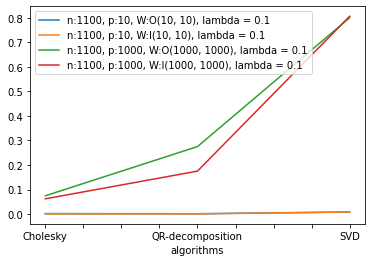

In [117]:
import matplotlib.pyplot as plt
ax = plt.gca()

table.plot(kind='line', x = 'algorithms', ax=ax)
plt.show()

In [118]:
numpy_table = table.drop(columns=["algorithms"]).to_numpy()

numpy_table

array([[0.001776, 0.000496, 0.074330, 0.062016],
       [0.001283, 0.000491, 0.274902, 0.174882],
       [0.008236, 0.008315, 0.800213, 0.806128]])